# Task#1: Sampling

In this notebook, we are to implement the *Langevin Dynamic* sampling method, usable for sampling from a distribution where *Z(teta)* is supposed to be a constant. Steps are provided as follows:
1. Create and visualize a 2D Gaussian distribution
2. Implement and visualize the score function
3. Implement Langevin Dynamics sampling with trajectories
4. Compare with NumPy's multivariate normal sampling

- Importing required libraries and set the random seed:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)

- **1.** Gaussian Distribution

    First, we create a 2D Gaussian with mean = [-5, 5] and covariance = 5I, then visualize it as a heatmap (Figure 1). The formula for a 2D Gaussian’s height (probability density) is:
    $$
    p(x) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
    $$
    We are ignoring the constant part in front (1/sqrt(...)) because it doesn’t affect the shape of the plot (it just scales the height, but the heatmap will normalize it). The part inside the exp is what we calculated: -0.5  (x - μ)^T Σ^{-1} (x - μ).

In [200]:
# Define 2D Gaussian function
def gaussian_2d(x, y, mu, cov):
    pos = np.array([x, y])
    diff = pos - mu
    inv_cov = np.linalg.inv(cov)
    exponent = -0.5 * diff.T @ inv_cov @ diff
    return np.exp(exponent)

# Parameters
mu = np.array([-5, 5])   # Mean
cov = 5 * np.eye(2)     # Covariance (5I)

# Create grid for visualization
x = np.linspace(-15, 15, 100)
y = np.linspace(-15, 15, 100)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

# Calculate Gaussian values
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = gaussian_2d(X[i, j], Y[i, j], mu, cov)

# Plot heatmap
plt.figure()
plt.contourf(X, Y, Z, levels=20, cmap='Reds')  
plt.title('Figure 1:Heatmap of 2D Gaussian')
plt.xlabel('x1')
plt.ylabel('x2')
plt.axis('square')
plt.show()

- 2. **Score Function**

    Next, we implement the score function ∇_x log p(x) and visualize it as a quiver plot (Figure 2).The score function shows the direction points should move to reach the peak of the Gaussian. For a probability distribution \( p(x) \), the score function is defined as the gradient of the log-probability:

    $$
    \text{score}(x) = \nabla_x \log p(x)
    $$

    For a 2D Gaussian with mean $\mu$ and covariance $\Sigma$, the probability density is:

    $$
    p(x) = \frac{1}{\sqrt{(2\pi)^d |\Sigma|}} \exp\left(-\frac{1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu)\right)
    $$

    Taking the log and computing the gradient, the score function simplifies to:

    $$
    \nabla_x \log p(x) = -\Sigma^{-1} (x - \mu)
    $$

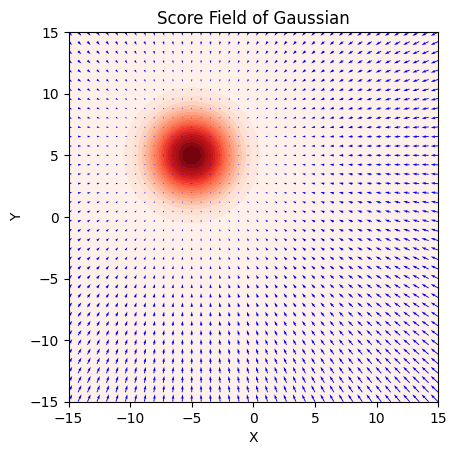

In [ ]:
# Define score function
def score_function(x, mu, cov):
    diff = x - mu
    inv_cov = np.linalg.inv(cov)
    return -inv_cov @ diff

# Create grid for score visualization
x_score = np.linspace(-15, 15, 40)  
y_score = np.linspace(-15, 15, 40)
X_score, Y_score = np.meshgrid(x_score, y_score)
U = np.zeros_like(X_score)
V = np.zeros_like(Y_score)

# Calculate score vectors
for i in range(X_score.shape[0]):
    for j in range(X_score.shape[1]):
        point = np.array([X_score[i, j], Y_score[i, j]])
        score = score_function(point, mu, cov)
        U[i, j] = score[0]
        V[i, j] = score[1]

# Plot score field overlaid on Gaussian heatmap
plt.figure()
plt.contourf(X, Y, Z, levels=20, cmap='Reds')
plt.quiver(X_score, Y_score, U, V, color='blue', scale=200)
plt.title('Score Field of Gaussian')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('square')
plt.show()

- 3. **Langevin Dynamics Sampling**

    We implement Langevin Dynamics to sample from the distribution and plot trajectories (Figure 3). We use Langevin Dynamics to sample from the Gaussian distribution $\ p(x)$. The update rule for Langevin Dynamics is:

    $$
    x_{t+1} = x_t + \epsilon \cdot \nabla_x \log p(x_t) + \sqrt{2\epsilon} \cdot \text{noise}
    $$

    where:
    - $\ x_t $: Position at step \( t \).
    - $\ epsilon $ = 0.1.
    - $\ \nabla_x \log p(x_t) = -\Sigma^{-1} (x_t - \mu) $: Score function, pointing toward the peak.
    - $\ \text{noise} \sim \mathcal{N}(0, 1) $: Random noise.
    - $\ \sqrt{2\epsilon} $: Scales the noise.

In [ ]:
# Define Langevin Dynamics
def langevin_dynamics(initial_points, mu, cov, epsilon=0.1, n_steps=100):
    n_samples = len(initial_points)
    trajectory = np.zeros((n_steps, n_samples, 2))
    samples = initial_points.copy()
    
    for t in range(n_steps):
        trajectory[t] = samples
        scores = np.array([score_function(x, mu, cov) for x in samples])
        noise = np.random.normal(0, 1, size=(n_samples, 2))
        samples = samples + epsilon * scores + np.sqrt(2 * epsilon) * noise
    
    return samples, trajectory

# Generate initial points and run sampling
n_samples = 1
initial_points = np.random.uniform(-15, 15, (n_samples, 2))
final_samples, trajectories = langevin_dynamics(initial_points, mu, cov)

# Plot trajectories
plt.figure()
plt.contourf(X, Y, Z, levels=20, cmap='Reds')

# Plot single trajectory
trajectory = trajectories[:, 0, :]
plt.plot(trajectory[:, 0], trajectory[:, 1], color='blue', alpha=1)

# Add arrows to indicate stepwise movement
for i in range(len(trajectory) - 1):
    plt.quiver(
        trajectory[i, 0], trajectory[i, 1],
        trajectory[i + 1, 0] - trajectory[i, 0],
        trajectory[i + 1, 1] - trajectory[i, 1],
        angles='xy', scale_units='xy', scale=1, color='blue', alpha=0.8, width=0.005
    )

# Mark final point
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='green', label="Langevin Sampling", marker='x', s=100)

# Labels and legend
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sampling Trajectories (Langevin)")
plt.legend()
plt.grid(True)
plt.xlim(-15, 15)
plt.ylim(-15, 15)
plt.axis('square')
# Show the plot
plt.show()


- 5. **Comparision:**

    NumPy Samples: Points are tightly clustered around [-5, 5] with a spread of ±5, forming a symmetric and circular distribution as expected for a Gaussian with Σ = 5I.

    Langevin Samples: Similarly centered around [0, 0] with a comparable spread, though with slightly more outliers due to its iterative nature and limited steps.

    Conclusion: Both methods produce nearly identical distributions, validating Langevin Dynamics' ability to sample from the target Gaussian. Any differences are due to the stochastic nature of the process.

In [ ]:
# Parameters
n_samples = 1000

# Sample using Langevin Dynamics
initial_points = np.random.uniform(-15, 15, (n_samples, 2))
langevin_samples, _ = langevin_dynamics(initial_points, mu, cov)

# Sample using numpy.random.multivariate_normal
numpy_samples = np.random.multivariate_normal(mu, cov, n_samples)

# Plot the samples side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot NumPy samples
ax1.scatter(numpy_samples[:, 0], numpy_samples[:, 1], s=10, alpha=0.5, color='blue')
ax1.set_title('Samples from numpy')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis')
ax1.grid(True)
ax1.set_xlim(-12, 12)
ax1.set_ylim(-2, 12)

# Plot Langevin samples
ax2.scatter(langevin_samples[:, 0], langevin_samples[:, 1], s=10, alpha=0.5, color='blue')
ax2.set_title('Langevin Sampling')
ax2.set_xlabel('X-axis')
ax2.set_ylabel('Y-axis')
ax2.grid(True)
ax2.set_xlim(-12, 12)
ax2.set_ylim(-2, 12)

plt.suptitle('Figure 4: comparing samples')
plt.tight_layout()
plt.show()

- 6. **Other Methods for Comparison:**

    1- **Calculation of mean and cov**: If the means and covariances are similar, it confirms that both methods are sampling from the same distribution.

In [213]:
# Compute means
numpy_mean = np.mean(numpy_samples, axis=0)
langevin_mean = np.mean(langevin_samples, axis=0)
print("NumPy Mean:", numpy_mean)
print("Langevin Mean:", langevin_mean)

# Compute covariances
numpy_cov = np.cov(numpy_samples, rowvar=False)
langevin_cov = np.cov(langevin_samples, rowvar=False)
print("NumPy Covariance:\n", numpy_cov)
print("Langevin Covariance:\n", langevin_cov)

NumPy Mean: [-4.97739431  5.00002137]
Langevin Mean: [-4.25350225  4.27760898]
NumPy Covariance:
 [[ 5.18489779 -0.26152075]
 [-0.26152075  5.3695926 ]]
Langevin Covariance:
 [[6.22985617 0.28939288]
 [0.28939288 6.4696191 ]]


2- **Using Q-Q Plot**: If the points lie on a straight line, the distributions are similar.

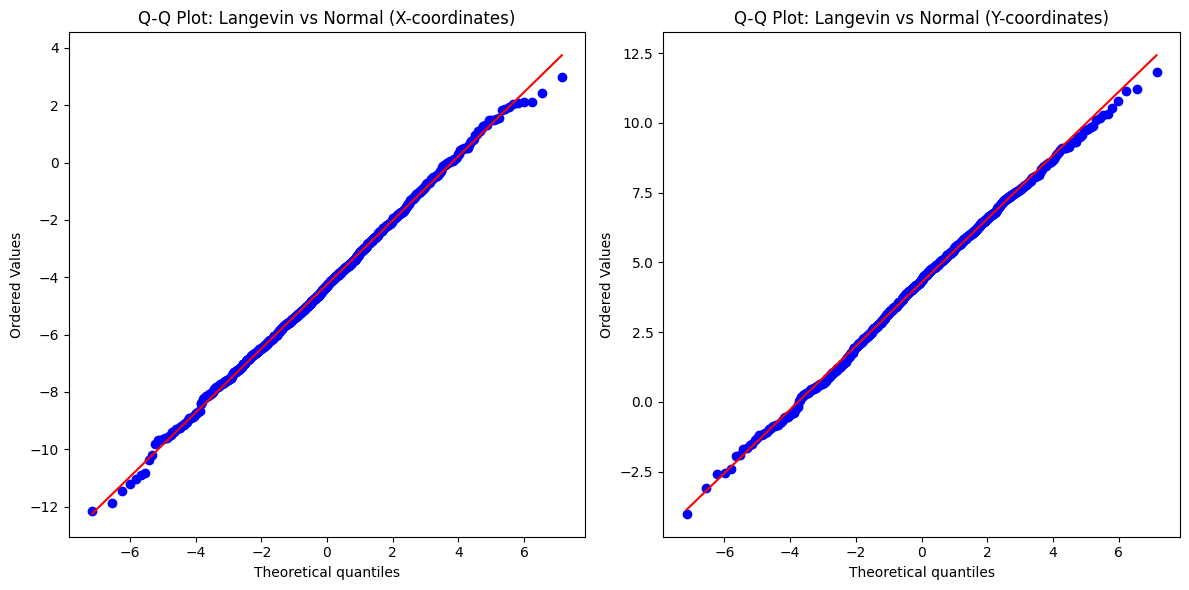

In [212]:
import scipy.stats as stats

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Q-Q plot for x-coordinates
stats.probplot(langevin_samples[:, 0], dist=stats.norm, sparams=(0, np.sqrt(5)), plot=ax1)
ax1.set_title('Q-Q Plot: Langevin vs Normal (X-coordinates)')

# Q-Q plot for y-coordinates
stats.probplot(langevin_samples[:, 1], dist=stats.norm, sparams=(0, np.sqrt(5)), plot=ax2)
ax2.set_title('Q-Q Plot: Langevin vs Normal (Y-coordinates)')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Questions(5% Bonus)

We are tasked with sampling from a mixture of Gaussians:

$$ \
p(x) = \alpha \mathcal{N}(x; \mu_1, \Sigma_1) + (1 - \alpha) \mathcal{N}(x; \mu_2, \Sigma_2)
$$ \

using Langevin Dynamics, which updates points as:

$$ \
x_{t+1} = x_t + \epsilon \cdot \nabla_x \log p(x_t) + \sqrt{2\epsilon} \cdot \text{noise}
$$ \

The score function is:

$$ \
\nabla_x \log p(x) = -\left( w_1(x) \Sigma_1^{-1} (x - \mu_1) + w_2(x) \Sigma_2^{-1} (x - \mu_2) \right)
$$ \

where $ \ w_1(x) = \frac{\alpha \mathcal{N}(x; \mu_1, \Sigma_1)}{p(x)} \ $ and $ \ w_2(x) = \frac{(1 - \alpha) \mathcal{N}(x; \mu_2, \Sigma_2)}{p(x)} \ $.

**Answer**: Yes, we can sample properly using Langevin Dynamics because the score function is computable. However, since the mixture may be multimodal, we must ensure:
- Initial points are well-distributed to capture both modes otherwise it will stuck in a loop.
- Enough steps are used to allow exploration between modes.
- The step size $ \epsilon  $ balances exploration and stability.